In [1]:
pip install pandas numpy matplotlib seaborn shap sweetviz

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Note: The following do not work with Python 3.12
import shap
# from ydata_profiling import ProfileReport
import sweetviz as sv

/home/samuel/Samuel/Coding/Projekte/Uni/BAML Project/baml-venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Reproducibility:

In [3]:
seed = 2024

# pandas, statsmodels, matplotlib and y_data_profiling rely on numpy's random generator, and thus, we need to set the seed in numpy
np.random.seed(seed)

Data Understanding

In [4]:
diet = pd.read_csv('diet.csv', low_memory=False)
diet['Diet'] = diet['Diet'].astype('category')

/tmp/ipykernel_76819/3693704536.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Diet', y='Age', data=diet, palette='pastel')


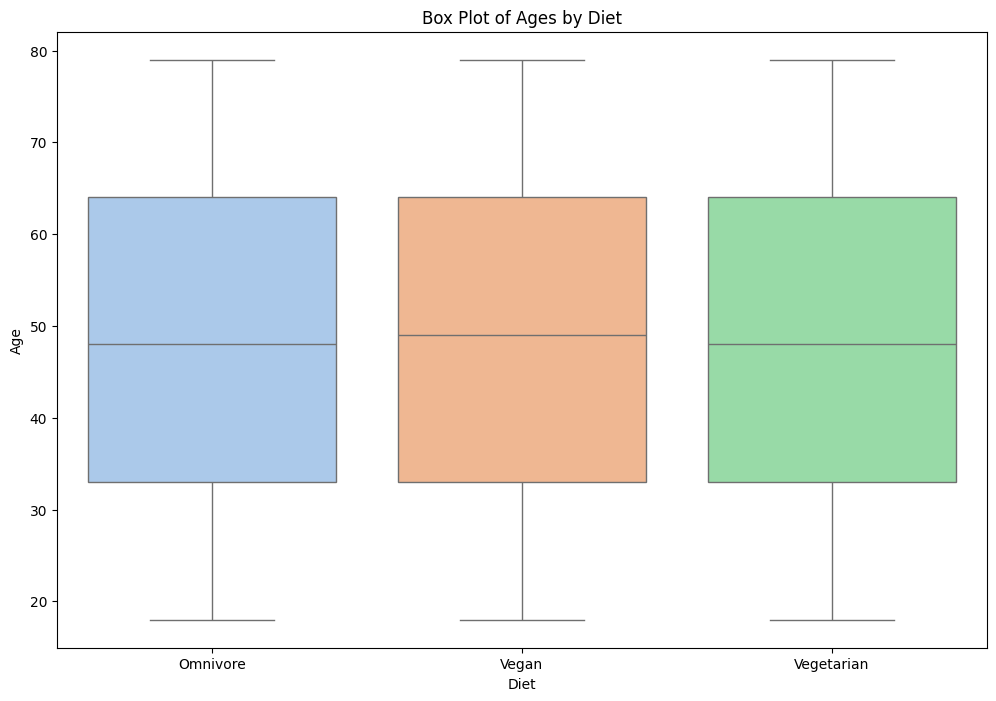

In [5]:
#Box Plot of Ages by Diet: Explore relationships between numerical variables (Age) using a pair plot.
plt.figure(figsize=(12, 8))
sns.boxplot(x='Diet', y='Age', data=diet, palette='pastel')
plt.title('Box Plot of Ages by Diet')
plt.xlabel('Diet')
plt.ylabel('Age')
plt.show()

In [6]:
requests = pd.read_csv('requests.csv', low_memory=False)
requests['HighProtein'] = requests['HighProtein'].astype('category')
requests['LowSugar'] = requests['LowSugar'].astype('category')

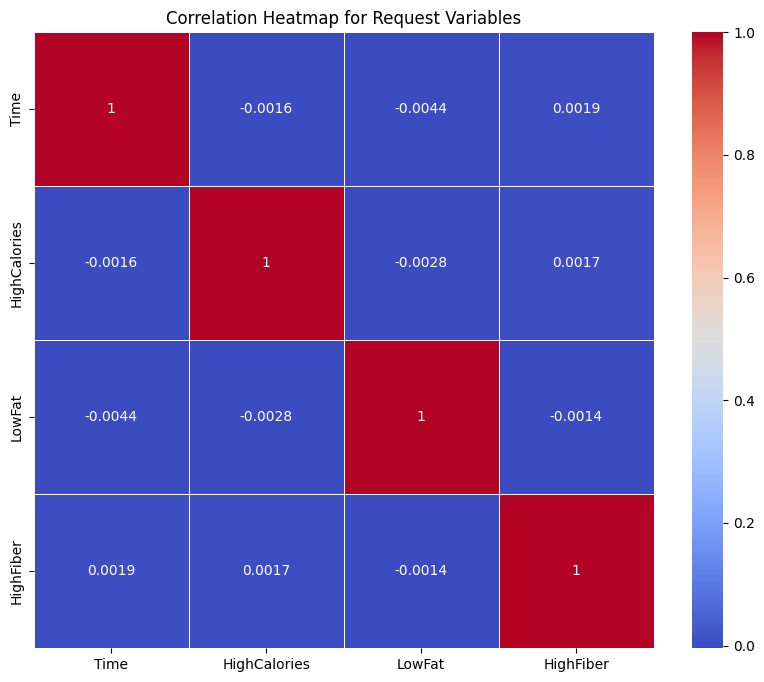

In [7]:
#Correlation Heatmap: Visualize the correlation between numerical variables.
# Exclude non-numeric columns
numeric_columns = requests[['Time', 'HighCalories', 'LowFat', 'HighFiber']]
correlation_matrix = numeric_columns.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap for Request Variables')
plt.show()

In [8]:
reviews = pd.read_csv('reviews.csv', low_memory=False)

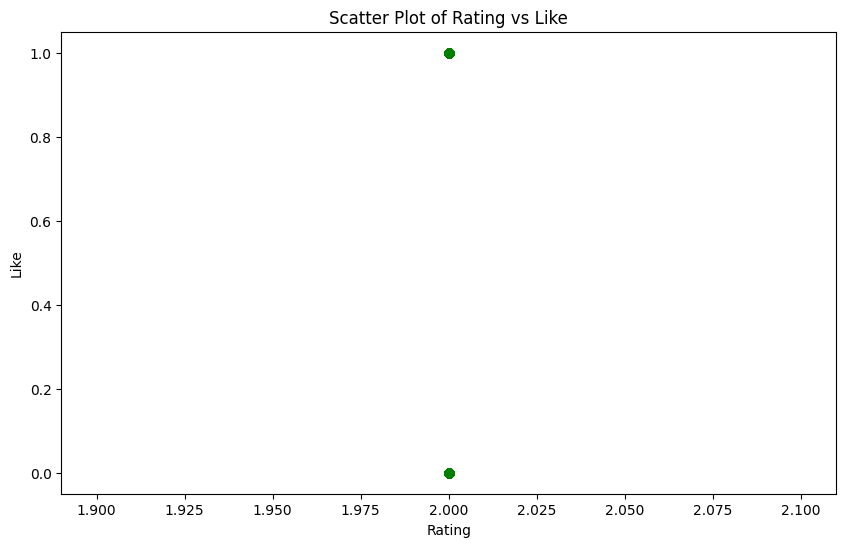

In [9]:
#Scatter Plot of Rating vs Like:Investigate the relationship between ratings and likes using a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(reviews['Rating'], reviews['Like'], alpha=0.5, color='green')
plt.title('Scatter Plot of Rating vs Like')
plt.xlabel('Rating')
plt.ylabel('Like')
plt.show()

In [10]:
recipes = pd.read_csv('recipes.csv/recipes.csv', low_memory=False)
recipes.rename(columns={
    'Name': 'RecipeName'
}, inplace=True)

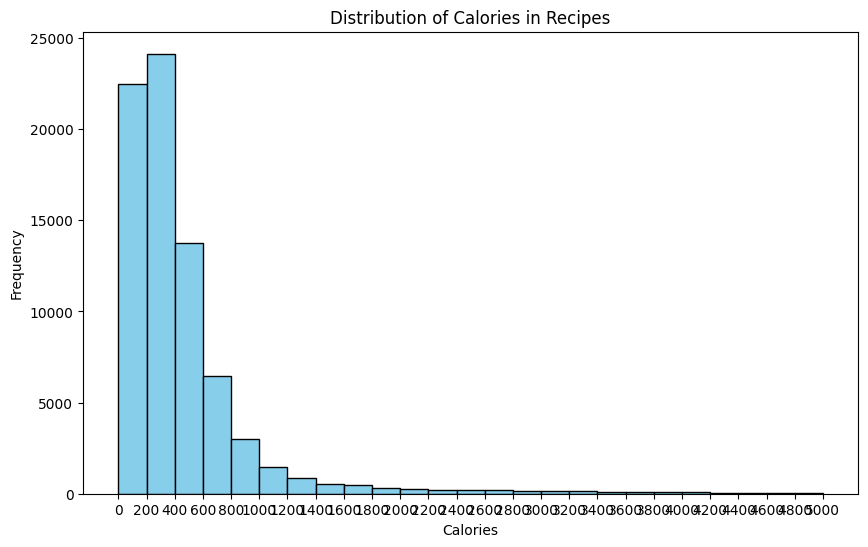

In [11]:
#Histogram for Calories:Explore the distribution of calories in recipes using a histogram.
custom_bins = np.arange(0, 5100, 200)  # Adjust the range and interval as needed

plt.figure(figsize=(10, 6))
plt.hist(recipes['Calories'], bins=custom_bins, color='skyblue', edgecolor='black')
plt.title('Distribution of Calories in Recipes')
plt.xlabel('Calories')
plt.ylabel('Frequency')

# Set x-axis labels
plt.xticks(custom_bins)

plt.show()

/tmp/ipykernel_76819/2506877081.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='RecipeCategory', y='CookTime', data=recipes, palette='Set2')


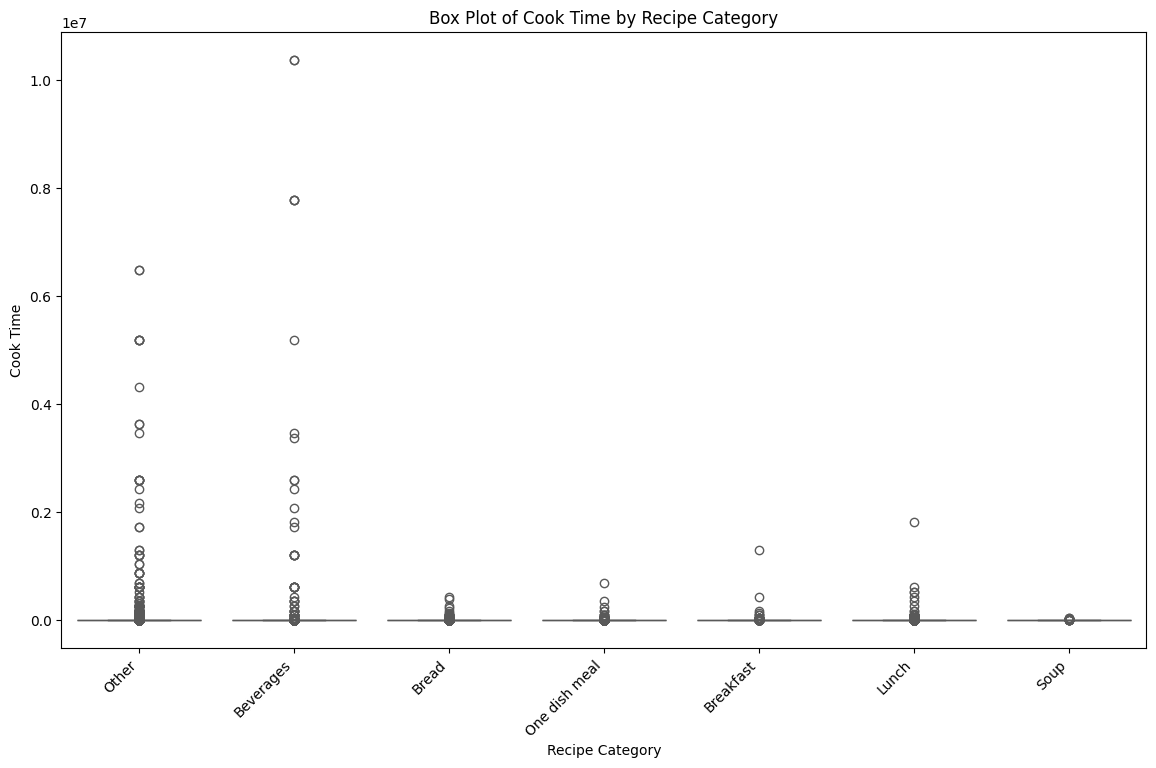

In [12]:
#Bar Plot for Recipe Categories: Visualize the distribution of recipes across different categories using a bar plot.
plt.figure(figsize=(14, 8))
sns.boxplot(x='RecipeCategory', y='CookTime', data=recipes, palette='Set2')
plt.title('Box Plot of Cook Time by Recipe Category')
plt.xlabel('Recipe Category')
plt.ylabel('Cook Time')
plt.xticks(rotation=45, ha='right')
plt.show()

In [13]:
merged_request_review = pd.merge(reviews,requests,on=['AuthorId','RecipeId'])

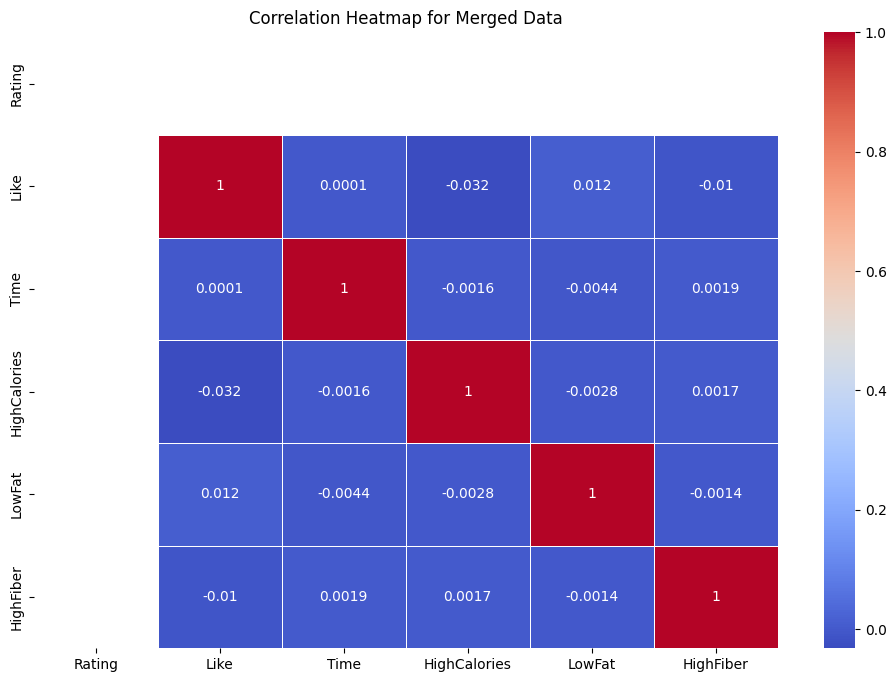

In [14]:
#Heatmap for Correlation: Visualize the correlation between numerical variables.
correlation_matrix = merged_request_review[['Rating', 'Like', 'Time', 'HighCalories', 'LowFat', 'HighFiber']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap for Merged Data')
plt.show()

Data Joining using common attributes

In [15]:
merged_recipes_req_review= pd.merge(merged_request_review,recipes,on=['RecipeId'],how='right')

In [16]:
author_ID = 'AuthorId'
merged_diet_all = pd.merge(diet, merged_recipes_req_review, on=author_ID)
# merged_request_recipes = pd.merge(requests, recipes, on='RecipeId', how='left')

Impute the missing values

In [17]:
# 1 value missing in diet column. Filled with most occuring value.
merged_diet_all['Diet'] = merged_diet_all['Diet'].fillna('Vegetarian')

In [18]:
#impute the values for all dietary preferences for all ages with the most frequent RecipeId for that age in that category
helper_df = merged_diet_all.groupby(['Age', 'Diet'])['RecipeId'].agg(lambda x: x.mode()[0]).reset_index()
helper_df.columns = ['Age', 'Diet', 'Most Common Recipe']
def impute_recipe(row):
    if pd.isnull(row['RecipeId']):
        return helper_df[(helper_df['Age'] == row['Age']) & (helper_df['Diet'] == row['Diet'])]['Most Common Recipe'].values[0]
    else:
        return row['RecipeId']
merged_diet_all['RecipeId'] = merged_diet_all.apply(impute_recipe, axis=1)

/tmp/ipykernel_76819/3258843432.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  helper_df = merged_diet_all.groupby(['Age', 'Diet'])['RecipeId'].agg(lambda x: x.mode()[0]).reset_index()


In [19]:
# Fill the rest of the missing values in the merged_diet_all by mapping them from requests.csv with RecipeId as key 
# Create mapping DataFrames from `requests`
map_time = requests.set_index('RecipeId')['Time'].to_dict()
map_calories = requests.set_index('RecipeId')['HighCalories'].to_dict()
map_protein = requests.set_index('RecipeId')['HighProtein'].to_dict()
map_fat = requests.set_index('RecipeId')['LowFat'].to_dict()
map_sugar = requests.set_index('RecipeId')['LowSugar'].to_dict()
map_fiber = requests.set_index('RecipeId')['HighFiber'].to_dict()

# Apply mapping to `merged_diet_all`
merged_diet_all['Time'] = merged_diet_all['RecipeId'].map(map_time)
merged_diet_all['HighCalories'] = merged_diet_all['RecipeId'].map(map_calories)
merged_diet_all['HighProtein'] = merged_diet_all['RecipeId'].map(map_protein)
merged_diet_all['LowFat'] = merged_diet_all['RecipeId'].map(map_fat)
merged_diet_all['LowSugar'] = merged_diet_all['RecipeId'].map(map_sugar)
merged_diet_all['HighFiber'] = merged_diet_all['RecipeId'].map(map_fiber)

In [20]:
map_name = recipes.set_index('RecipeId')['RecipeName'].to_dict()
map_cook_time = recipes.set_index('RecipeId')['CookTime'].to_dict()
map_prep_time = recipes.set_index('RecipeId')['PrepTime'].to_dict()
map_category = recipes.set_index('RecipeId')['RecipeCategory'].to_dict()
map_quantities = recipes.set_index('RecipeId')['RecipeIngredientQuantities'].to_dict()
map_parts = recipes.set_index('RecipeId')['RecipeIngredientParts'].to_dict()
map_calories = recipes.set_index('RecipeId')['Calories'].to_dict()
map_fat_content = recipes.set_index('RecipeId')['FatContent'].to_dict()
map_saturated_content = recipes.set_index('RecipeId')['SaturatedFatContent'].to_dict()
map_cholesterol = recipes.set_index('RecipeId')['CholesterolContent'].to_dict()
map_sodium = recipes.set_index('RecipeId')['SodiumContent'].to_dict()
map_carbohydrate = recipes.set_index('RecipeId')['CarbohydrateContent'].to_dict()
map_fiber = recipes.set_index('RecipeId')['FiberContent'].to_dict()
map_sugar = recipes.set_index('RecipeId')['SugarContent'].to_dict()
map_protein = recipes.set_index('RecipeId')['ProteinContent'].to_dict()
map_servings = recipes.set_index('RecipeId')['RecipeServings'].to_dict()
map_yield = recipes.set_index('RecipeId')['RecipeYield'].to_dict()


# Apply mapping to `merged_diet_all`
merged_diet_all['RecipeName'] = merged_diet_all['RecipeId'].map(map_name)
merged_diet_all['CookTime'] = merged_diet_all['RecipeId'].map(map_cook_time)
merged_diet_all['PrepTime'] = merged_diet_all['RecipeId'].map(map_prep_time)
merged_diet_all['RecipeCategory'] = merged_diet_all['RecipeId'].map(map_category)
merged_diet_all['RecipeIngredientQuantities'] = merged_diet_all['RecipeId'].map(map_quantities)
merged_diet_all['RecipeIngredientParts'] = merged_diet_all['RecipeId'].map(map_parts)
merged_diet_all['Calories'] = merged_diet_all['RecipeId'].map(map_calories)
merged_diet_all['FatContent'] = merged_diet_all['RecipeId'].map(map_fat)
merged_diet_all['SaturatedFatContent'] = merged_diet_all['RecipeId'].map(map_saturated_content)
merged_diet_all['CholesterolContent'] = merged_diet_all['RecipeId'].map(map_cholesterol)
merged_diet_all['SodiumContent'] = merged_diet_all['RecipeId'].map(map_sodium)
merged_diet_all['CarbohydrateContent'] = merged_diet_all['RecipeId'].map(map_carbohydrate)
merged_diet_all['FiberContent'] = merged_diet_all['RecipeId'].map(map_fiber)
merged_diet_all['SugarContent'] = merged_diet_all['RecipeId'].map(map_sugar)
merged_diet_all['ProteinContent'] = merged_diet_all['RecipeId'].map(map_protein)
merged_diet_all['RecipeServings'] = merged_diet_all['RecipeId'].map(map_servings)
merged_diet_all['RecipeYield'] = merged_diet_all['RecipeId'].map(map_yield)

In [21]:
merged_diet_all['Rating'] = merged_diet_all['Rating'].fillna(0)
merged_diet_all['TestSetId'] = merged_diet_all['TestSetId']

Balance the proportion of True and False

In [22]:
# Assuming df is your DataFrame
df = merged_diet_all
# Calculate the proportion of true and false values in the 'Like' column
import pandas as pd
import numpy as np

# Assuming df is your DataFrame
# Calculate the proportion of true and false values in the 'Like' column
proportion_true = df['Like'].mean()
proportion_false = 1 - proportion_true

# Identify the indices of false values
false_indices = df[df['Like'] == False].index

# Randomly sample false indices to achieve a balanced proportion
num_false_to_sample = int(df['Like'].value_counts()[True] / proportion_true) - df['Like'].value_counts()[False]
indices_to_sample = np.random.choice(false_indices, size=num_false_to_sample, replace=False)

# Create a new DataFrame with sampled false values
df_balanced = pd.concat([df[df['Like'] == True], df.loc[indices_to_sample]])

# Shuffle the new DataFrame to randomize the order
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Print the proportion of true and false values in the balanced DataFrame
print(df_balanced['Like'].value_counts(normalize=True))

Like
True     0.5
False    0.5
Name: proportion, dtype: float64


Train a Gradient Boosting Classifier

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import balanced_accuracy_score
# 72.7 WITH 2000 ADD
# Load your data
df = df_balanced

# Define features (X) and target variable (y)
features = ['Diet', 'Age', 'Rating', 'Time', 'HighCalories','HighProtein','LowFat','LowSugar','HighFiber', 'CookTime', 'PrepTime','RecipeCategory', 'RecipeCategory', 'Calories', 'FatContent','SaturatedFatContent', 'CholesterolContent', 'SodiumContent',  'CarbohydrateContent','FiberContent', 'SugarContent', 'ProteinContent']


target = 'Like'

# Drop rows with NaN values in the target column ('Like') and create a copy for training set
train_data = df.dropna(subset=[target]).copy()

# Convert 'Like' column to boolean (if not already)
train_data['Like'] = train_data['Like'].astype(bool)

# Split the data into features (X) and target variable (y)
X = train_data[features]
y = train_data['Like']

# Handle categorical variables using one-hot encoding
X = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Gradient Boosting model
model = GradientBoostingClassifier(
    n_estimators=100,     # You can adjust this
    random_state=42,
    learning_rate=0.1,    # You can adjust this
    max_depth=3,          # You can adjust this
    min_samples_split=2,  # You can adjust this
    min_samples_leaf=1,   # You can adjust this
    subsample=1.0         # You can adjust this
)


# Fit the model on the training set
model.fit(X_train, y_train)

# Evaluate the model on the training set
y_train_pred = model.predict(X_train)

# Compute balanced accuracy for the training set
balanced_accuracy_train = balanced_accuracy_score(y_train, y_train_pred)
print(f"Balanced Accuracy on Training Set: {balanced_accuracy_train:.4f}")

# Predict the 'Like' column for the testing set
y_test_pred = model.predict(X_test)

# Compute balanced accuracy for the testing set
balanced_accuracy_test = balanced_accuracy_score(y_test, y_test_pred)
print(f"Balanced Accuracy on Testing Set: {balanced_accuracy_test:.4f}")

Balanced Accuracy on Training Set: 0.7730
Balanced Accuracy on Testing Set: 0.7590


Neural Network Classifier

In [24]:
pip install pandas numpy scikit-learn tensorflow

Note: you may need to restart the kernel to use updated packages.


In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load your data
df = df_balanced

# Define features (X) and target variable (y)
features = ['Diet', 'Age', 'Rating', 'Time', 'HighCalories', 'HighProtein', 'LowFat', 'LowSugar', 'HighFiber',
            'CookTime', 'PrepTime', 'RecipeCategory', 'RecipeCategory', 'Calories', 'FatContent',
            'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent',
            'SugarContent', 'ProteinContent']

target = 'Like'

# Drop rows with NaN values in the target column ('Like') and create a copy for the training set
train_data = df.dropna(subset=[target]).copy()

# Convert 'Like' column to boolean (if not already)
train_data['Like'] = train_data['Like'].astype(bool)

# Split the data into features (X) and target variable (y)
X = train_data[features]
y = train_data['Like']

# Handle categorical variables using one-hot encoding
X = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Neural Network model
model = Sequential()

# Add the first hidden layer with 10 neurons and 'relu' activation function
model.add(Dense(units=10, activation='relu', input_dim=X_train_scaled.shape[1]))

# Add the second hidden layer with 5 neurons and 'relu' activation function
model.add(Dense(units=5, activation='relu'))

# Output layer with 1 neuron and 'sigmoid' activation function for binary classification
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model on the training set
model.fit(X_train_scaled, y_train, epochs=20, batch_size=30, validation_split=0.2)

# Evaluate the model on the testing set
y_test_pred = model.predict(X_test_scaled)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

# Compute balanced accuracy for the testing set
balanced_accuracy_test = balanced_accuracy_score(y_test, y_test_pred_binary)
print(f"Balanced Accuracy on Testing Set: {balanced_accuracy_test:.4f}")

2024-08-08 00:05:15.851028: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-08 00:05:15.851582: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-08 00:05:15.853532: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-08 00:05:15.858966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 00:05:15.868088: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

Epoch 1/20


/home/samuel/Samuel/Coding/Projekte/Uni/BAML Project/baml-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


550/550 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5435 - loss: 0.6880 - val_accuracy: 0.6760 - val_loss: 0.6046
Epoch 2/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6824 - loss: 0.5907 - val_accuracy: 0.6870 - val_loss: 0.5714
Epoch 3/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6974 - loss: 0.5630 - val_accuracy: 0.7095 - val_loss: 0.5578
Epoch 4/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - accuracy: 0.7204 - loss: 0.5506 - val_accuracy: 0.7183 - val_loss: 0.5469
Epoch 5/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - accuracy: 0.7313 - loss: 0.5363 - val_accuracy: 0.7185 - val_loss: 0.5413
Epoch 6/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7351 - loss: 0.5335 - val_accuracy: 0.7231 - val_loss: 0.5361
Epoch 7/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step - accuracy: 0.7350 - loss: 0.5327 - val_accuracy: 0.7251 - val_loss: 0.5283
Epoch 8/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.7309 - loss: 0.5265 - val_accuracy: 0.732

Training a Random Forest Classifier

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from itertools import combinations

# Load your data
df = df_balanced

# Define features (X) and target variable (y)
features = ['Diet','Age', 'Rating', 'Time', 'CookTime', 'FiberContent', 'ProteinContent', 'SugarContent',  'SodiumContent', 'CholesterolContent', 'SaturatedFatContent', 'FatContent', 'Calories', 'HighFiber', 'HighCalories', 'RecipeCategory', 'HighProtein']
target = 'Like'

# Drop rows with NaN values in the target column ('Like') and create a copy for training set
train_data = df.dropna(subset=[target]).copy()

# Convert 'Like' column to boolean (if not already)
train_data['Like'] = train_data['Like'].astype(bool)

# Get all possible combinations of features


best_combination = None
best_accuracy = 0.0

# Iterate over all feature combinations
# Split the data into features (X) and target variable (y)
X = train_data[features]
y = train_data['Like']

# Handle categorical variables using one-hot encodin
X = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model with hyperparameter tuning
model_final_rfc = RandomForestClassifier(
    n_estimators=100,
    random_state=47,
    max_depth=10,
    min_samples_split=6,
    min_samples_leaf=5,
    max_features='sqrt'
)

# Fit the model on the training set
model_final_rfc.fit(X_train, y_train)

# Evaluate the model on the testing set
y_test_pred = model_final_rfc.predict(X_test)
balanced_accuracy_train = balanced_accuracy_score(y_train, y_train_pred)
print(f"Balanced Accuracy on Training Set: {balanced_accuracy_train:.4f}")
# Compute balanced accuracy for the testing set
balanced_accuracy_test = balanced_accuracy_score(y_test, y_test_pred)

# Print the feature combination and its balanced accuracy
# print(f"Balanced Accuracy on Training Set: {balanced_accuracy_test:.4f}")

print(f"Balanced Accuracy on Testing Set: {balanced_accuracy_test:.4f}")

Balanced Accuracy on Training Set: 0.7730
Balanced Accuracy on Testing Set: 0.7621


Deploy the model

In [27]:
features = ['Diet','Age', 'Rating', 'Time', 'CookTime', 'FiberContent', 'ProteinContent', 'SugarContent',  'SodiumContent', 'CholesterolContent', 'SaturatedFatContent', 'FatContent', 'Calories', 'HighFiber', 'HighCalories', 'RecipeCategory', 'HighProtein','TestSetId','Like']
df = merged_diet_all[features].copy()

# Drop and save testsetid
# Drop rows with NaN values in the target column ('Like') for training set
predict_data = df[df['Like'].isna()]
predict_data

predict_data = predict_data.sort_values(by='TestSetId', ascending=True)
predict_data
# 1. One-Hot Encode Categorical Variables in predict_data
predict_features = predict_data[features]  # 'features' list from your model training code
predict_features_encoded = pd.get_dummies(predict_features)

# 2. Align the Columns of predict_data with X_train
# Add missing columns in predict_features_encoded with value equal to 0
missing_cols = set(X_train.columns) - set(predict_features_encoded.columns)
for c in missing_cols:
    predict_features_encoded[c] = 0

# Ensure the order of columns in predict_features_encoded matches that of X_train
predict_features_encoded = predict_features_encoded[X_train.columns]

# 3. Make Predictions Using the Trained Model
predicted_likes = model_final_rfc.predict(predict_features_encoded)

# Combine Predictions with 'TestSetId'
results_df = pd.DataFrame({
    'id': predict_data['TestSetId'],
    'prediction': predicted_likes
})
results_df['id'] = results_df['id'].astype(int)
results_df['prediction'] = results_df['prediction'].replace({True: 1, False: 0})


# Display the first few rows of the results
print(results_df.head())
results_df.to_csv('predictions_skilled_shark.csv',index=False)
results_df

        id  prediction
92733    1           0
70540    2           1
110017   3           0
64367    4           1
61048    5           1


/tmp/ipykernel_76819/665919965.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_df['prediction'] = results_df['prediction'].replace({True: 1, False: 0})


,id,prediction
92733,1,0
70540,2,1
110017,3,0
64367,4,1
61048,5,1
...,...,...
48455,42810,0
48454,42811,0
100493,42812,0
63212,42813,0
